In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process
from gaussian_process_hyperparameter_tuning import optimise_hyperparameters


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

In [3]:
enc = OneHotEncoder()

In [4]:
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))

In [5]:
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names(one_hot_encode))

In [6]:
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)

In [7]:
hyperparameters = [
    [("max_features", ['auto', 'sqrt', 'log2']),
    ("criterion", ['gini','entropy'])],
    
    [("n_estimators", np.arange(1, 1000, 1)),
    ("max_depth", np.arange(1, 1000, 1)),
    ("min_samples_split", np.arange(2, 100, 1)),
    ("min_samples_leaf", np.arange(1, 50, 1)),
    ("min_impurity_decrease", np.arange(0.0, 1.0, 0.01))]
]

In [11]:
import itertools
categorical_hyperparameters = ["-".join(y) for y in itertools.product(*[x[1] for x in hyperparameters[0]])]
ranges = [x[1] for x in hyperparameters[1]]
gp_datas = {c:(np.zeros((0, len(ranges))), np.zeros((0))) for c in categorical_hyperparameters}

In [13]:
categorical_hyperparameters

['auto-gini',
 'auto-entropy',
 'sqrt-gini',
 'sqrt-entropy',
 'log2-gini',
 'log2-entropy']

In [14]:
hyperparameters = [
    [("weights", ['uniform', 'distance'])],
    [("n_neighbors", np.arange(4, 100, 1)),
     ("leaf_size", np.arange(5, 100, 5))]
]

In [15]:
X = np.random.random((1000, 2))
y = np.array([int(x* 5) for x in np.random.random((1000))])
for i in range(10):
    for j in range(100):
        distances = np.hypot(*(X - X[j,:]).T)
        closest = np.argpartition(distances, 5)[:20]
        labels = y[closest]
        unique, counts = np.unique(labels, return_counts=True)
        label = unique[counts.argmax()]
        y = np.array([y[ii] if ii not in closest else label for ii in range(1000)])
        
        
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4]), array([351,  61, 194, 174, 220]))

In [16]:
kernel = RBF(1.0)
result = optimise_hyperparameters(KNeighborsClassifier, hyperparameters, 500, X, y, 10, kernel=kernel)

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.


/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/pyt

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/pyt

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.


/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.


/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/pyt

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/pyt

In [21]:
from sklearn.utils.extmath import cartesian

In [22]:
        sets = [np.random.choice(range_, 10) for range_ in ranges]
        combinations = cartesian(sets)

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
gaussian = GaussianProcessRegressor()

In [27]:
mean, sigma = gaussian.predict(combinations, return_std=True)

In [32]:
predicted_rewards = np.array([np.random.normal(m, s) for m, s in zip(mean, sigma)])

In [37]:
    categorical_hyperparameters = ["-".join(y) for y in itertools.product(*[x[1] for x in hyperparameters[0]])]
    ranges = [x[1] for x in hyperparameters[1]]
    gaussian = GaussianProcessRegressor()
    gp_datas = {c:(np.zeros((0, len(ranges))), np.zeros((0))) for c in categorical_hyperparameters}

    counts = {c:0.001 for c in categorical_hyperparameters}
    rewards = {c:[1] for c in categorical_hyperparameters}

In [39]:
        n_sample = 10
        ucb = np.array([np.mean(rewards[c])*10 + np.sqrt(2*np.sum(list(counts.values()))/count) for c, count in counts.items()])
        selected_arm = categorical_hyperparameters[ucb.argmax()]
        counts[selected_arm] = int(counts[selected_arm]+1)

        if gp_datas[selected_arm][0].shape[0] > 0:
            gaussian.fit(gp_datas[selected_arm][0], gp_datas[selected_arm][1])

        sets = [np.random.choice(range_, n_sample) for range_ in ranges]
        combinations = cartesian(sets)

        mean, sigma = gaussian.predict(combinations, return_std=True)

        predicted_rewards = np.array([np.random.normal(m, s) for m, s in zip(mean, sigma)])

        hyperparameter_values = selected_arm.split("-") + combinations[np.argmax(predicted_rewards)].tolist()
        arguments = zip([x[0] for x in hyperparameters[0]] + [x[0] for x in hyperparameters[1]], hyperparameter_values)

In [40]:
score = 0.8

In [41]:
        gp_datas[selected_arm] = (np.concatenate([gp_datas[selected_arm][0], combinations[np.argmax(predicted_rewards)].reshape((1, -1))], 0),
                                  np.concatenate([gp_datas[selected_arm][1], [score]]))
        rewards[selected_arm] += [score]

In [42]:
gp_datas

{'uniform': (array([], shape=(0, 2), dtype=float64), array([], dtype=float64)),
 'distance': (array([[56., 80.]]), array([0.8]))}

In [18]:
result['uniform'][0]

array([[ 7., 10.],
       [29., 50.],
       [48., 75.],
       [83., 30.],
       [10., 85.],
       [37., 30.],
       [31., 90.],
       [71., 45.],
       [58., 75.],
       [11., 95.],
       [46., 55.],
       [93., 55.],
       [ 9., 95.],
       [98., 90.],
       [86.,  5.],
       [ 5., 40.],
       [24.,  5.],
       [ 9.,  5.],
       [14., 35.],
       [ 4., 15.],
       [98., 10.],
       [ 4., 60.],
       [82., 90.],
       [94., 80.],
       [20., 10.],
       [20., 60.],
       [72., 25.],
       [50., 15.],
       [18., 45.],
       [13., 15.],
       [31., 70.],
       [70., 95.],
       [97., 45.],
       [16., 75.],
       [44.,  5.],
       [26., 85.],
       [22., 75.],
       [11., 40.],
       [84., 15.],
       [ 8., 70.],
       [76., 70.],
       [17., 95.],
       [60., 30.],
       [ 8., 10.],
       [16., 25.],
       [14., 25.],
       [17., 20.],
       [71., 80.],
       [76., 10.],
       [38., 35.],
       [54., 65.],
       [95., 25.],
       [ 4.,

In [35]:
        hyperparameter_values = selected_arm.split("-") + combinations[np.argmax(predicted_rewards)].tolist()

NameError: name 'selected_arm' is not defined

In [34]:
result['uniform'][1]

array([0.834, 0.817, 0.777, 0.741, 0.828, 0.798, 0.814, 0.757, 0.776,
       0.833, 0.782, 0.732, 0.829, 0.722, 0.735, 0.822, 0.827, 0.829,
       0.836, 0.811, 0.722, 0.811, 0.74 , 0.728, 0.828, 0.828, 0.756,
       0.778, 0.832, 0.836, 0.814, 0.759, 0.722, 0.834, 0.784, 0.822,
       0.826, 0.833, 0.738, 0.829, 0.747, 0.834, 0.775, 0.829, 0.834,
       0.836, 0.834, 0.757, 0.747, 0.797, 0.775, 0.728, 0.811, 0.772,
       0.733, 0.771, 0.814, 0.825, 0.771, 0.732, 0.822, 0.791, 0.792,
       0.814, 0.774, 0.747, 0.747, 0.825, 0.771, 0.774, 0.754, 0.828,
       0.726, 0.836, 0.832, 0.826, 0.771, 0.791, 0.774, 0.775, 0.803,
       0.739, 0.811, 0.787, 0.756, 0.819, 0.741, 0.827, 0.795, 0.736,
       0.827, 0.791, 0.736, 0.828, 0.833, 0.754, 0.834, 0.829, 0.722,
       0.809, 0.811, 0.811, 0.809, 0.742, 0.836, 0.725, 0.757, 0.797,
       0.822, 0.774, 0.771, 0.836, 0.825, 0.775, 0.826, 0.819, 0.756,
       0.834, 0.777, 0.78 , 0.834, 0.728, 0.811, 0.836, 0.834, 0.722,
       0.782, 0.777,

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(result['uniform'][0], result['uniform'][1])

GaussianProcessRegressor(kernel=RBF(length_scale=1))

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


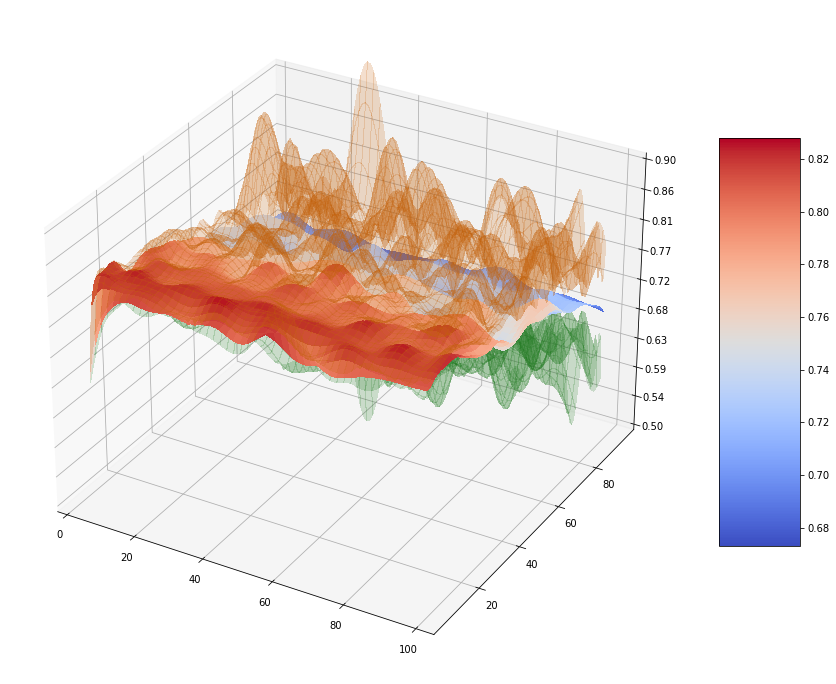

In [42]:
visualise_2D_gaussian_process(gaussian, np.arange(4, 100, 1), np.arange(5, 100, 5), np.arange(0.5, 1, 0.1))